In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, metrics, decomposition

import torch
import os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import Data_Prep.Graph_Data as gd
from Data_Prep.Graph_Data import Molecule_data
from math import sqrt
# from torch_geometric.nn import GATv2Conv
from models.attenFP_v1 import AttentionConvNet
# from optuna_v1.attenFP_v1 import AttentionConvNet

In [2]:
def createFoldsData():
    iy = 0
    folds = 10
    for fold in tqdm(range(folds)):
        df_train = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_train.csv')
        df_test  = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_test.csv')
        smiles = df_train['SMILES']
#         codIds = df_train['CODID']
        band_gap = df_train['logS']
        band_gap = band_gap.to_numpy()

        smiles_test = df_test['SMILES']
#         codIds_test = df_test['CODID']
        band_gap_test = df_test['logS']
        band_gap_test = band_gap_test.to_numpy()


        smile_graph = {}
        band_gap_arr = []
        smiles_array = []

        for i,smile in enumerate(smiles):
            g = gd.smile_to_graph(smile)
            if g != None:
                smile_graph[smile] = g
                band_gap_arr.append(band_gap[i])
                smiles_array.append(smile)

        smile_graph_test = {}
        band_gap_arr_test = []
        smiles_array_test = []

        for i,smile in enumerate(smiles_test):
            g = gd.smile_to_graph(smile)
            if g != None:
                smile_graph_test[smile] = g
                band_gap_arr_test.append(band_gap_test[i])
                smiles_array_test.append(smile)

        train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(iy),y=band_gap_arr,
                                   smile_graph=smile_graph,smiles=smiles_array)

        test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(iy),y=band_gap_arr_test,
                                   smile_graph=smile_graph_test,smiles=smiles_array_test)

        iy+=1

In [3]:
df = pd.read_csv('Data_Prep/solubility_1.csv')
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
smiles = df['SMILES']
# codIds = df['CODID']
band_gap = df['logS']

In [5]:
band_gap = band_gap.to_numpy()

In [6]:
def createFoldsCsv():
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=10,shuffle = True, random_state = 2) #, random_state = 2
    ix = 0
    train1 = df
    for train_index, test_index in (kf.split(train1)):
        print ("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train,X_test=train1.iloc[train_index], train1.iloc[test_index]
        X_train.to_csv('New_fold/fold_'+str(ix)+'_'+'x_train.csv',index=False)
        X_test.to_csv('New_fold/fold_'+str(ix)+'_'+'x_test.csv',index=False)
        ix+=1
    createFoldsData()

In [7]:
processed_data_file_train = 'data/processed/' + 'train_data_set_fold_'+str(0)+'.pt'
processed_data_file_test = 'data/processed/'  + 'test_data_set_fold_'+str(0)+'.pt'
if ((not os.path.isfile(processed_data_file_train)) or (not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
        createFoldsCsv()

In [8]:
if torch.cuda.is_available():  
    device = "cuda:7"
    print("cuda:7")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:7


In [9]:
def train(model, optimizer,train_loader):
    train_labels = 0
    train_predictions = 0
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        # out = model(data)
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("train : ", y.shape)
        loss = F.mse_loss(out1, y)
        loss.backward()
        optimizer.step()
#         train_labels += train_labels + y
#         train_predictions += train_predictions + out1
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return total_loss,sqrt(total_loss / total_examples)

In [10]:
@torch.no_grad()
def test(loader, model):
    # mse = []
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        # out = model(data)
        # mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        # return float(torch.cat(mse, dim=0).mean().sqrt())
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("test : ", y.shape)
        test_loss = F.mse_loss(out1, y)
        # print("no of graphs: ", data.num_graphs)
        total_loss += float(test_loss) * data.num_graphs
        total_examples += data.num_graphs
#         total_preds = torch.cat((total_preds, out1.cpu()), 0)
#         total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
        # mse.append(test_loss).cpu()
    # return test_loss,float(torch.cat(mse, dim=0).mean().sqrt())
    return total_loss,sqrt(total_loss / total_examples) #,total_labels.numpy().flatten(),total_preds.numpy().flatten()

In [11]:
# Generate the model.

# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0021931604377098835,
#                                weight_decay=1.2733069489371785e-05)
the_last_loss = 100
patience = 30
trigger_times = 0
count_loss_difference = 0
#LR = 0.005
learning_rate = 0.00688267742977242
weight_decay=0.000307616688331247
#LR = 0.0028894537419258915
LOG_INTERVAL = 20
NUM_EPOCHS = 200
results = []
TRAIN_BATCH_SIZE = 64

In [12]:
best_ret = []
best_mse = 0.80
best_ci = 0
best_epoch = -1

In [13]:
folds = 10
results = []
best_rmse_arr = []
scores = []
true_val = []
pred_val = []
for fold in tqdm(range(folds)):
    model = AttentionConvNet().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    result_file_name = 'result_' + str(fold) +  '.csv'
    
    train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    model
    
    
    train_loader   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,
#                     num_layers=3, num_timesteps=2,
#                     dropout=0.047352327938708194).to(device)
    best_ret = []
    
#     model = model.cuda(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     best_mae = 0.00
    
    for epoch in range(NUM_EPOCHS):
        train_loss,train_rmse=train(model, optimizer,train_loader)
        test_loss,test_rmse = test(test_loader, model)
#         score = metrics.r2_score(true, prediction)
#         , true, prediction
        
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} '
          f'Test: {test_rmse:.4f} ') #f'score: {score:.4f} '   
        
        ret = [epoch,train_rmse,test_rmse]
        
        train_losses.append(train_rmse)
        val_losses.append(test_rmse)
#         scores.append(score)
        # Early Stopping
        the_current_loss = test_rmse   #.item()
        best_ret.append(ret)
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)
    
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
        else:
            ret = [epoch,train_rmse,test_rmse] #, score
            trigger_times = 0
            the_last_loss = the_current_loss
            best_rmse = the_current_loss
            
            torch.save(model.state_dict(), model_file_name)
        # Early stopping
#         the_current_loss = test_loss.item()
        
#         best_ret.append(ret)
        
#         if the_current_loss > the_last_loss:
#             trigger_times += 1
#             print('trigger times:', trigger_times)
            
#             if trigger_times >= patience:
#                 print('Early stopping!\nStart to test process.')
#                 break
#         else:
#             ret = [epoch,train_loss,test_loss.item()]
#             trigger_times = 0
#             best_mae = the_current_loss
#             the_last_loss = the_current_loss
            
#             torch.save(model.state_dict(), model_file_name)

    results.append(best_ret)
    best_rmse_arr.append(best_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 000, Loss: 1.7414 Test: 1.3998 
Epoch: 001, Loss: 1.4517 Test: 1.4380 
trigger times: 1
Epoch: 002, Loss: 1.3908 Test: 1.3181 
Epoch: 003, Loss: 1.3960 Test: 1.3828 
trigger times: 1
Epoch: 004, Loss: 1.3700 Test: 1.2738 
Epoch: 005, Loss: 1.3461 Test: 1.2370 
Epoch: 006, Loss: 1.3548 Test: 1.3104 
trigger times: 1
Epoch: 007, Loss: 1.3390 Test: 1.2331 
Epoch: 008, Loss: 1.3344 Test: 1.2506 
trigger times: 1
Epoch: 009, Loss: 1.3303 Test: 1.2198 
Epoch: 010, Loss: 1.3366 Test: 1.2300 
trigger times: 1
Epoch: 011, Loss: 1.3300 Test: 1.2250 
trigger times: 2
Epoch: 012, Loss: 1.3231 Test: 1.2289 
trigger times: 3
Epoch: 013, Loss: 1.3214 Test: 1.2199 
trigger times: 4
Epoch: 014, Loss: 1.3199 Test: 1.2101 
Epoch: 015, Loss: 1.3276 Test: 1.2275 
trigger times: 1
Epoch: 016, Loss: 1.3230 Test: 1.2305 
trigger times: 2
Epoch: 017, Loss: 1.3381 Test: 1.2233 
trigger times: 3
Epoch: 018, Loss: 1.3322 Test: 1.2292 
trigger times: 4
Epoch: 019, Loss: 1.3186 Test: 1.3194 
trigger times: 5

Epoch: 013, Loss: 1.3122 Test: 1.2994 
trigger times: 7
Epoch: 014, Loss: 1.2961 Test: 1.2983 
trigger times: 8
Epoch: 015, Loss: 1.2834 Test: 1.2858 
Epoch: 016, Loss: 1.2905 Test: 1.3094 
trigger times: 1
Epoch: 017, Loss: 1.3112 Test: 1.2945 
trigger times: 2
Epoch: 018, Loss: 1.2961 Test: 1.2976 
trigger times: 3
Epoch: 019, Loss: 1.2833 Test: 1.2849 
Epoch: 020, Loss: 1.2742 Test: 1.3213 
trigger times: 1
Epoch: 021, Loss: 1.2837 Test: 1.3259 
trigger times: 2
Epoch: 022, Loss: 1.2801 Test: 1.2843 
Epoch: 023, Loss: 1.2866 Test: 1.4912 
trigger times: 1
Epoch: 024, Loss: 1.2766 Test: 1.2959 
trigger times: 2
Epoch: 025, Loss: 1.2904 Test: 1.2860 
trigger times: 3
Epoch: 026, Loss: 1.2843 Test: 1.2888 
trigger times: 4
Epoch: 027, Loss: 1.2903 Test: 1.3411 
trigger times: 5
Epoch: 028, Loss: 1.2906 Test: 1.2855 
trigger times: 6
Epoch: 029, Loss: 1.2784 Test: 1.3014 
trigger times: 7
Epoch: 030, Loss: 1.2956 Test: 1.2852 
trigger times: 8
Epoch: 031, Loss: 1.2831 Test: 1.3288 
trig

Epoch: 015, Loss: 1.3177 Test: 1.3604 
trigger times: 1
Epoch: 016, Loss: 1.3151 Test: 1.2197 
trigger times: 2
Epoch: 017, Loss: 1.2967 Test: 1.3145 
trigger times: 3
Epoch: 018, Loss: 1.3047 Test: 1.2293 
trigger times: 4
Epoch: 019, Loss: 1.3175 Test: 1.2837 
trigger times: 5
Epoch: 020, Loss: 1.3125 Test: 1.2210 
trigger times: 6
Epoch: 021, Loss: 1.3088 Test: 1.2241 
trigger times: 7
Epoch: 022, Loss: 1.3008 Test: 1.2480 
trigger times: 8
Epoch: 023, Loss: 1.2978 Test: 1.3689 
trigger times: 9
Epoch: 024, Loss: 1.3091 Test: 1.2647 
trigger times: 10
Epoch: 025, Loss: 1.3004 Test: 1.2373 
trigger times: 11
Epoch: 026, Loss: 1.2920 Test: 1.2119 
Epoch: 027, Loss: 1.2993 Test: 1.2029 
Epoch: 028, Loss: 1.2836 Test: 1.3579 
trigger times: 1
Epoch: 029, Loss: 1.3121 Test: 1.2489 
trigger times: 2
Epoch: 030, Loss: 1.3128 Test: 1.2476 
trigger times: 3
Epoch: 031, Loss: 1.2911 Test: 1.1984 
Epoch: 032, Loss: 1.3080 Test: 1.2396 
trigger times: 1
Epoch: 033, Loss: 1.2975 Test: 1.2166 
tr

Epoch: 167, Loss: 1.2445 Test: 1.3873 
trigger times: 21
Epoch: 168, Loss: 1.2717 Test: 1.2034 
trigger times: 22
Epoch: 169, Loss: 1.2454 Test: 1.1669 
trigger times: 23
Epoch: 170, Loss: 1.2558 Test: 1.2148 
trigger times: 24
Epoch: 171, Loss: 1.2626 Test: 1.3116 
trigger times: 25
Epoch: 172, Loss: 1.2552 Test: 1.1668 
trigger times: 26
Epoch: 173, Loss: 1.2492 Test: 1.2835 
trigger times: 27
Epoch: 174, Loss: 1.2491 Test: 1.1675 
trigger times: 28
Epoch: 175, Loss: 1.2551 Test: 1.2048 
trigger times: 29
Epoch: 176, Loss: 1.2661 Test: 1.1588 
trigger times: 30
Early stopping!
Start to test process.
Epoch: 000, Loss: 2.0862 Test: 1.6479 
Epoch: 001, Loss: 1.5018 Test: 1.5324 
Epoch: 002, Loss: 1.4208 Test: 1.4911 
Epoch: 003, Loss: 1.3808 Test: 1.4933 
trigger times: 1
Epoch: 004, Loss: 1.3699 Test: 1.4995 
trigger times: 2
Epoch: 005, Loss: 1.3505 Test: 1.4797 
Epoch: 006, Loss: 1.3438 Test: 1.5194 
trigger times: 1
Epoch: 007, Loss: 1.3479 Test: 1.4929 
trigger times: 2
Epoch: 008,

Epoch: 018, Loss: 1.3187 Test: 1.3593 
trigger times: 2
Epoch: 019, Loss: 1.3104 Test: 1.3467 
Epoch: 020, Loss: 1.3151 Test: 1.3666 
trigger times: 1
Epoch: 021, Loss: 1.3298 Test: 1.4590 
trigger times: 2
Epoch: 022, Loss: 1.3088 Test: 1.4923 
trigger times: 3
Epoch: 023, Loss: 1.3160 Test: 1.3603 
trigger times: 4
Epoch: 024, Loss: 1.3004 Test: 1.3771 
trigger times: 5
Epoch: 025, Loss: 1.2948 Test: 1.3730 
trigger times: 6
Epoch: 026, Loss: 1.2914 Test: 1.3737 
trigger times: 7
Epoch: 027, Loss: 1.3200 Test: 1.3712 
trigger times: 8
Epoch: 028, Loss: 1.2927 Test: 1.3449 
Epoch: 029, Loss: 1.3036 Test: 1.3566 
trigger times: 1
Epoch: 030, Loss: 1.3037 Test: 1.3608 
trigger times: 2
Epoch: 031, Loss: 1.2926 Test: 1.3400 
Epoch: 032, Loss: 1.3214 Test: 1.3743 
trigger times: 1
Epoch: 033, Loss: 1.2890 Test: 1.3696 
trigger times: 2
Epoch: 034, Loss: 1.2954 Test: 1.3266 
Epoch: 035, Loss: 1.2929 Test: 1.3322 
trigger times: 1
Epoch: 036, Loss: 1.2923 Test: 1.3515 
trigger times: 2
Epoc

Epoch: 088, Loss: 1.2518 Test: 1.2142 
trigger times: 21
Epoch: 089, Loss: 1.2462 Test: 1.2482 
trigger times: 22
Epoch: 090, Loss: 1.2725 Test: 1.2001 
trigger times: 23
Epoch: 091, Loss: 1.2647 Test: 1.2616 
trigger times: 24
Epoch: 092, Loss: 1.2528 Test: 1.2483 
trigger times: 25
Epoch: 093, Loss: 1.2501 Test: 1.2132 
trigger times: 26
Epoch: 094, Loss: 1.2540 Test: 1.2120 
trigger times: 27
Epoch: 095, Loss: 1.2489 Test: 1.2240 
trigger times: 28
Epoch: 096, Loss: 1.2706 Test: 1.2011 
trigger times: 29
Epoch: 097, Loss: 1.2651 Test: 1.2181 
trigger times: 30
Early stopping!
Start to test process.
Epoch: 000, Loss: 1.7316 Test: 1.4199 
Epoch: 001, Loss: 1.3602 Test: 1.2958 
Epoch: 002, Loss: 1.3390 Test: 1.3035 
trigger times: 1
Epoch: 003, Loss: 1.2986 Test: 1.2903 
Epoch: 004, Loss: 1.2792 Test: 1.2555 
Epoch: 005, Loss: 1.3183 Test: 1.2864 
trigger times: 1
Epoch: 006, Loss: 1.2813 Test: 1.2383 
Epoch: 007, Loss: 1.2634 Test: 1.2353 
Epoch: 008, Loss: 1.2809 Test: 1.2284 
Epoch:

In [14]:
format_float = "{:.2f}".format(best_rmse)

In [15]:
type(format_float)

str

In [16]:
resSt = results[0][1]

In [17]:
res_val = resSt

In [18]:
res_val

[1, 1.4516923435313405, 1.4380451801306202]

65
65
75
75
90
90
58
58
177
177
36
36
86
86
82
82
98
98
44
44


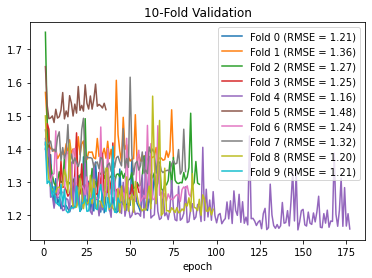

In [19]:
folds = 10
for fold in range(folds):
    train_loss_arr = []
    test_loss_arr = []
    for res in results[fold]:
        train_loss_arr.append(res[1])
        test_loss_arr.append(res[2])
    
    print(len(train_loss_arr))
    print(len(test_loss_arr))
    ax = plt.subplot(1,1,1)
    
    ax.WindowState = 'maximized';

    format_mae = "{:.2f}".format(best_rmse_arr[fold])
    
  #  ax.plot([e for e in range(1,len(train_loss_arr) + 1)], train_loss_arr, label="train_loss")
    ax.plot([e for e in range(1,len(test_loss_arr) + 1)],
            test_loss_arr, label="Fold " + str(fold) + " (RMSE = " + format_mae + ")")
    plt.xlabel("epoch")
    ax.title.set_text('10-Fold Validation')
    ax.legend()
    ax.figure.savefig('Visualization/'+str(fold)+'.png')

In [20]:
# whole data set as training dataset
def createTestData(path,filename,datasetname):
    iy = 0
#     folds = 10
#     for fold in tqdm(range(folds)):
#     df_train = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_train.csv')
#     df_test  = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_test.csv')
#     smiles = df_train['SMILES']
#         codIds = df_train['CODID']
#     solubility = df_train['logS']
#     solubility = solubility.to_numpy()
    df_test = pd.read_csv(path + '/' + filename)
#     df_test  = pd.read_csv('New_fold/testset_novel.csv')
    smiles_test = df_test['SMILES']
#         codIds_test = df_test['CODID']
    solubility_test = df_test['logS']
    solubility_test = solubility_test.to_numpy()


#     smile_graph = {}
#     solubility_arr = []
#     smiles_array = []
    smile_graph_test = {}
    solubility_arr_test = []
    smiles_array_test = []

    for i,smile in enumerate(smiles_test):
        g = gd.smile_to_graph(smile)
        if g != None:
            smile_graph_test[smile] = g
            solubility_arr_test.append(smiles_test[i])
            smiles_array_test.append(smile)

#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(iy),y=band_gap_arr,
#                                smile_graph=smile_graph,smiles=smiles_array)

    noveltest_data = Molecule_data(root='data', dataset=datasetname,y=solubility_test,
                               smile_graph=smile_graph_test,smiles=smiles_array_test)
    return noveltest_data
#     iy+=1

In [21]:
@torch.no_grad()
def predicting(loader, model):
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        # out = model(data)
        # mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        # return float(torch.cat(mse, dim=0).mean().sqrt())
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("test : ", y.shape)
        test_loss = F.mse_loss(out1, y)
        # print("no of graphs: ", data.num_graphs)
        total_loss += float(test_loss) * data.num_graphs
        total_examples += data.num_graphs
        total_preds = torch.cat((total_preds, out.view(-1, 1).cpu()), 0)
        total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
#         print("total_labels : ", total_labels.shape)
#         print("total_preds : ", total_preds.shape)
        # mse.append(test_loss).cpu()
    # return test_loss,float(torch.cat(mse, dim=0).mean().sqrt())
    return total_loss,sqrt(total_loss / total_examples),total_labels.numpy().flatten(),total_preds.numpy().flatten()

  0%|          | 0/10 [00:00<?, ?it/s]

Test R2:  0.6574429672822961
Test RMSE:  1.303948737260316
Test R2:  0.6015885744767353
Test RMSE:  1.4046734405309862
Test R2:  0.6455395478824696
Test RMSE:  1.301445075731461
Test R2:  0.6293370043046664
Test RMSE:  1.2980245217580573
Test R2:  0.7054230536687284
Test RMSE:  1.1758533456368179
Test R2:  0.5285370028568857
Test RMSE:  1.4954343260041718
Test R2:  0.6425186935951372
Test RMSE:  1.3198057209459249
Test R2:  0.6359658219169131
Test RMSE:  1.3612499651639005
Test R2:  0.6950136096852224
Test RMSE:  1.200597803169813
Test R2:  0.6978540125148618
Test RMSE:  1.2663308520184056


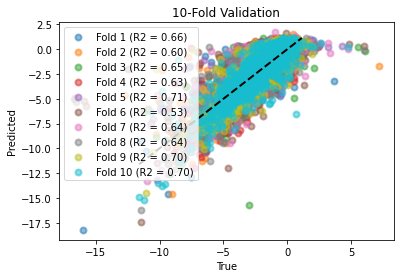

In [22]:
# 10 fold cross validation set results. Calculating pearson correlations.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
fig = plt.figure()
for fold in tqdm(range(folds)):
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
#     TRAIN_BATCH_SIZE = 40
    test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = AttentionConvNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
#     result_file_name = 'novelresult_' + str(fold) +  '.csv'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     model.load_state_dict(torch.load(model_file_name))
    
    test_loss,test_rmse, true, prediction = predicting(test_loader, model)
    
    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE: ', test_rmse)
    plt.scatter(prediction, true, lw=2, alpha=0.5, 
                label='Fold %d (R2 = %0.2f)' % (fold+1,score))
plt.plot([min(prediction),max(true)], [min(prediction),max(true)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('10-Fold Validation')
plt.legend()
plt.savefig('TestR2.png')
plt.show()
# avg = bestrmsesum/10
# print('10 fold avg is : ', avg)

In [23]:
# training whole dataset. first loading each fold model and train on whole dataset
folds = 10
results = []
best_rmse_arr = []
scores = []
true_val = []
pred_val = []
wholetrain_data = createTestData('Data_Prep','solubility_1.csv','solubility_1')
for fold in tqdm(range(folds)):
    wholetrain_loader  = DataLoader(wholetrain_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = AttentionConvNet().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    load_model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    model_file_name = 'saved_models/wholetrainmodel_' +  str(fold) +  '.model'
    result_file_name = 'wholetrainresult_' + str(fold) +  '.csv'
    checkpoint = torch.load(load_model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
    train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
#     test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
#     TRAIN_BATCH_SIZE = 64
    
#     train_loader   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,
#                     num_layers=3, num_timesteps=2,
#                     dropout=0.047352327938708194).to(device)
    best_ret = []
    
#     model = model.cuda(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     best_mae = 0.00
    
    for epoch in range(NUM_EPOCHS):
        train_loss,train_rmse=train(model, optimizer,train_loader)
#         test_loss,test_rmse = test(test_loader, model)
#         score = metrics.r2_score(true, prediction)
#         , true, prediction
        
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} '
          ) #f'Test: {test_rmse:.4f} 'f'score: {score:.4f} '   
        
        ret = [epoch,train_rmse]
        
        train_losses.append(train_rmse)
#         val_losses.append(test_rmse)
#         scores.append(score)
        # Early Stopping
        the_current_loss = train_rmse   #.item()
        best_ret.append(ret)
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)
    
            if trigger_times >= 200:   #patience
                print('Early stopping!\nStart to test process.')
                break
        else:
            ret = [epoch,train_rmse] #, ,test_rmse, score
            trigger_times = 0
            the_last_loss = the_current_loss
            best_rmse = the_current_loss
            
            torch.save(model.state_dict(), model_file_name)
        # Early stopping
#         the_current_loss = test_loss.item()
        
#         best_ret.append(ret)
        
#         if the_current_loss > the_last_loss:
#             trigger_times += 1
#             print('trigger times:', trigger_times)
            
#             if trigger_times >= patience:
#                 print('Early stopping!\nStart to test process.')
#                 break
#         else:
#             ret = [epoch,train_loss,test_loss.item()]
#             trigger_times = 0
#             best_mae = the_current_loss
#             the_last_loss = the_current_loss
            
#             torch.save(model.state_dict(), model_file_name)

    results.append(best_ret)
    best_rmse_arr.append(best_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 000, Loss: 1.3986 
Epoch: 001, Loss: 1.3735 
Epoch: 002, Loss: 1.3771 
trigger times: 1
Epoch: 003, Loss: 1.3858 
trigger times: 2
Epoch: 004, Loss: 1.3917 
trigger times: 3
Epoch: 005, Loss: 1.3790 
trigger times: 4
Epoch: 006, Loss: 1.3566 
Epoch: 007, Loss: 1.3635 
trigger times: 1
Epoch: 008, Loss: 1.3841 
trigger times: 2
Epoch: 009, Loss: 1.3653 
trigger times: 3
Epoch: 010, Loss: 1.3878 
trigger times: 4
Epoch: 011, Loss: 1.3732 
trigger times: 5
Epoch: 012, Loss: 1.3607 
trigger times: 6
Epoch: 013, Loss: 1.3641 
trigger times: 7
Epoch: 014, Loss: 1.3682 
trigger times: 8
Epoch: 015, Loss: 1.3875 
trigger times: 9
Epoch: 016, Loss: 1.3755 
trigger times: 10
Epoch: 017, Loss: 1.3715 
trigger times: 11
Epoch: 018, Loss: 1.3591 
trigger times: 12
Epoch: 019, Loss: 1.3742 
trigger times: 13
Epoch: 020, Loss: 1.3645 
trigger times: 14
Epoch: 021, Loss: 1.3696 
trigger times: 15
Epoch: 022, Loss: 1.3608 
trigger times: 16
Epoch: 023, Loss: 1.3681 
trigger times: 17
Epoch: 024,

Epoch: 190, Loss: 1.3557 
trigger times: 112
Epoch: 191, Loss: 1.3932 
trigger times: 113
Epoch: 192, Loss: 1.3570 
trigger times: 114
Epoch: 193, Loss: 1.3897 
trigger times: 115
Epoch: 194, Loss: 1.3758 
trigger times: 116
Epoch: 195, Loss: 1.3596 
trigger times: 117
Epoch: 196, Loss: 1.3641 
trigger times: 118
Epoch: 197, Loss: 1.3732 
trigger times: 119
Epoch: 198, Loss: 1.3604 
trigger times: 120
Epoch: 199, Loss: 1.3485 
trigger times: 121
Epoch: 000, Loss: 1.4065 
Epoch: 001, Loss: 1.4049 
Epoch: 002, Loss: 1.3778 
Epoch: 003, Loss: 1.3877 
trigger times: 1
Epoch: 004, Loss: 1.3869 
trigger times: 2
Epoch: 005, Loss: 1.3841 
trigger times: 3
Epoch: 006, Loss: 1.3782 
trigger times: 4
Epoch: 007, Loss: 1.3873 
trigger times: 5
Epoch: 008, Loss: 1.3806 
trigger times: 6
Epoch: 009, Loss: 1.4065 
trigger times: 7
Epoch: 010, Loss: 1.3763 
Epoch: 011, Loss: 1.3768 
trigger times: 1
Epoch: 012, Loss: 1.3628 
Epoch: 013, Loss: 1.3821 
trigger times: 1
Epoch: 014, Loss: 1.3965 
trigger

Epoch: 180, Loss: 1.3750 
trigger times: 69
Epoch: 181, Loss: 1.3844 
trigger times: 70
Epoch: 182, Loss: 1.3815 
trigger times: 71
Epoch: 183, Loss: 1.3788 
trigger times: 72
Epoch: 184, Loss: 1.3789 
trigger times: 73
Epoch: 185, Loss: 1.3769 
trigger times: 74
Epoch: 186, Loss: 1.3749 
trigger times: 75
Epoch: 187, Loss: 1.4289 
trigger times: 76
Epoch: 188, Loss: 1.4236 
trigger times: 77
Epoch: 189, Loss: 1.4128 
trigger times: 78
Epoch: 190, Loss: 1.3693 
trigger times: 79
Epoch: 191, Loss: 1.3828 
trigger times: 80
Epoch: 192, Loss: 1.3740 
trigger times: 81
Epoch: 193, Loss: 1.3751 
trigger times: 82
Epoch: 194, Loss: 1.3828 
trigger times: 83
Epoch: 195, Loss: 1.3895 
trigger times: 84
Epoch: 196, Loss: 1.3948 
trigger times: 85
Epoch: 197, Loss: 1.3838 
trigger times: 86
Epoch: 198, Loss: 1.3829 
trigger times: 87
Epoch: 199, Loss: 1.3795 
trigger times: 88
Epoch: 000, Loss: 1.3150 
Epoch: 001, Loss: 1.2927 
Epoch: 002, Loss: 1.2978 
trigger times: 1
Epoch: 003, Loss: 1.2877 

Epoch: 172, Loss: 1.2666 
trigger times: 6
Epoch: 173, Loss: 1.2788 
trigger times: 7
Epoch: 174, Loss: 1.2896 
trigger times: 8
Epoch: 175, Loss: 1.2858 
trigger times: 9
Epoch: 176, Loss: 1.2785 
trigger times: 10
Epoch: 177, Loss: 1.2654 
trigger times: 11
Epoch: 178, Loss: 1.2914 
trigger times: 12
Epoch: 179, Loss: 1.2833 
trigger times: 13
Epoch: 180, Loss: 1.2731 
trigger times: 14
Epoch: 181, Loss: 1.2795 
trigger times: 15
Epoch: 182, Loss: 1.2770 
trigger times: 16
Epoch: 183, Loss: 1.2618 
trigger times: 17
Epoch: 184, Loss: 1.2636 
trigger times: 18
Epoch: 185, Loss: 1.2724 
trigger times: 19
Epoch: 186, Loss: 1.2732 
trigger times: 20
Epoch: 187, Loss: 1.2676 
trigger times: 21
Epoch: 188, Loss: 1.2662 
trigger times: 22
Epoch: 189, Loss: 1.2841 
trigger times: 23
Epoch: 190, Loss: 1.2826 
trigger times: 24
Epoch: 191, Loss: 1.2785 
trigger times: 25
Epoch: 192, Loss: 1.2665 
trigger times: 26
Epoch: 193, Loss: 1.2830 
trigger times: 27
Epoch: 194, Loss: 1.2779 
trigger ti

Epoch: 163, Loss: 1.3472 
trigger times: 62
Epoch: 164, Loss: 1.3583 
trigger times: 63
Epoch: 165, Loss: 1.3440 
trigger times: 64
Epoch: 166, Loss: 1.3643 
trigger times: 65
Epoch: 167, Loss: 1.3518 
trigger times: 66
Epoch: 168, Loss: 1.3650 
trigger times: 67
Epoch: 169, Loss: 1.3420 
trigger times: 68
Epoch: 170, Loss: 1.3574 
trigger times: 69
Epoch: 171, Loss: 1.3637 
trigger times: 70
Epoch: 172, Loss: 1.3532 
trigger times: 71
Epoch: 173, Loss: 1.3576 
trigger times: 72
Epoch: 174, Loss: 1.3705 
trigger times: 73
Epoch: 175, Loss: 1.3342 
Epoch: 176, Loss: 1.3703 
trigger times: 1
Epoch: 177, Loss: 1.3507 
trigger times: 2
Epoch: 178, Loss: 1.3550 
trigger times: 3
Epoch: 179, Loss: 1.3518 
trigger times: 4
Epoch: 180, Loss: 1.3531 
trigger times: 5
Epoch: 181, Loss: 1.3780 
trigger times: 6
Epoch: 182, Loss: 1.3606 
trigger times: 7
Epoch: 183, Loss: 1.3548 
trigger times: 8
Epoch: 184, Loss: 1.3454 
trigger times: 9
Epoch: 185, Loss: 1.3460 
trigger times: 10
Epoch: 186, Los

Epoch: 153, Loss: 1.2722 
trigger times: 57
Epoch: 154, Loss: 1.2763 
trigger times: 58
Epoch: 155, Loss: 1.2663 
trigger times: 59
Epoch: 156, Loss: 1.2811 
trigger times: 60
Epoch: 157, Loss: 1.2652 
trigger times: 61
Epoch: 158, Loss: 1.2712 
trigger times: 62
Epoch: 159, Loss: 1.2594 
trigger times: 63
Epoch: 160, Loss: 1.2863 
trigger times: 64
Epoch: 161, Loss: 1.2924 
trigger times: 65
Epoch: 162, Loss: 1.2683 
trigger times: 66
Epoch: 163, Loss: 1.2694 
trigger times: 67
Epoch: 164, Loss: 1.2836 
trigger times: 68
Epoch: 165, Loss: 1.2829 
trigger times: 69
Epoch: 166, Loss: 1.2584 
trigger times: 70
Epoch: 167, Loss: 1.2609 
trigger times: 71
Epoch: 168, Loss: 1.2712 
trigger times: 72
Epoch: 169, Loss: 1.2946 
trigger times: 73
Epoch: 170, Loss: 1.2915 
trigger times: 74
Epoch: 171, Loss: 1.2743 
trigger times: 75
Epoch: 172, Loss: 1.2761 
trigger times: 76
Epoch: 173, Loss: 1.2688 
trigger times: 77
Epoch: 174, Loss: 1.2890 
trigger times: 78
Epoch: 175, Loss: 1.2957 
trigge

Epoch: 150, Loss: 1.2816 
trigger times: 25
Epoch: 151, Loss: 1.2926 
trigger times: 26
Epoch: 152, Loss: 1.2842 
trigger times: 27
Epoch: 153, Loss: 1.2965 
trigger times: 28
Epoch: 154, Loss: 1.2697 
trigger times: 29
Epoch: 155, Loss: 1.2765 
trigger times: 30
Epoch: 156, Loss: 1.2767 
trigger times: 31
Epoch: 157, Loss: 1.2795 
trigger times: 32
Epoch: 158, Loss: 1.2695 
trigger times: 33
Epoch: 159, Loss: 1.2857 
trigger times: 34
Epoch: 160, Loss: 1.2765 
trigger times: 35
Epoch: 161, Loss: 1.2881 
trigger times: 36
Epoch: 162, Loss: 1.2802 
trigger times: 37
Epoch: 163, Loss: 1.2694 
trigger times: 38
Epoch: 164, Loss: 1.2741 
trigger times: 39
Epoch: 165, Loss: 1.2799 
trigger times: 40
Epoch: 166, Loss: 1.3302 
trigger times: 41
Epoch: 167, Loss: 1.2654 
trigger times: 42
Epoch: 168, Loss: 1.2993 
trigger times: 43
Epoch: 169, Loss: 1.2773 
trigger times: 44
Epoch: 170, Loss: 1.2837 
trigger times: 45
Epoch: 171, Loss: 1.2810 
trigger times: 46
Epoch: 172, Loss: 1.2826 
trigge

Epoch: 140, Loss: 1.3570 
trigger times: 125
Epoch: 141, Loss: 1.3459 
trigger times: 126
Epoch: 142, Loss: 1.3630 
trigger times: 127
Epoch: 143, Loss: 1.3667 
trigger times: 128
Epoch: 144, Loss: 1.3834 
trigger times: 129
Epoch: 145, Loss: 1.3386 
Epoch: 146, Loss: 1.3622 
trigger times: 1
Epoch: 147, Loss: 1.3720 
trigger times: 2
Epoch: 148, Loss: 1.3773 
trigger times: 3
Epoch: 149, Loss: 1.3689 
trigger times: 4
Epoch: 150, Loss: 1.3535 
trigger times: 5
Epoch: 151, Loss: 1.3492 
trigger times: 6
Epoch: 152, Loss: 1.3560 
trigger times: 7
Epoch: 153, Loss: 1.3603 
trigger times: 8
Epoch: 154, Loss: 1.3838 
trigger times: 9
Epoch: 155, Loss: 1.3545 
trigger times: 10
Epoch: 156, Loss: 1.3505 
trigger times: 11
Epoch: 157, Loss: 1.3686 
trigger times: 12
Epoch: 158, Loss: 1.3588 
trigger times: 13
Epoch: 159, Loss: 1.3582 
trigger times: 14
Epoch: 160, Loss: 1.3682 
trigger times: 15
Epoch: 161, Loss: 1.3580 
trigger times: 16
Epoch: 162, Loss: 1.3791 
trigger times: 17
Epoch: 163

Epoch: 131, Loss: 1.3004 
trigger times: 40
Epoch: 132, Loss: 1.3111 
trigger times: 41
Epoch: 133, Loss: 1.2998 
trigger times: 42
Epoch: 134, Loss: 1.3227 
trigger times: 43
Epoch: 135, Loss: 1.3178 
trigger times: 44
Epoch: 136, Loss: 1.3266 
trigger times: 45
Epoch: 137, Loss: 1.3054 
trigger times: 46
Epoch: 138, Loss: 1.3114 
trigger times: 47
Epoch: 139, Loss: 1.3302 
trigger times: 48
Epoch: 140, Loss: 1.3185 
trigger times: 49
Epoch: 141, Loss: 1.3020 
trigger times: 50
Epoch: 142, Loss: 1.3236 
trigger times: 51
Epoch: 143, Loss: 1.3040 
trigger times: 52
Epoch: 144, Loss: 1.3114 
trigger times: 53
Epoch: 145, Loss: 1.3059 
trigger times: 54
Epoch: 146, Loss: 1.3246 
trigger times: 55
Epoch: 147, Loss: 1.3231 
trigger times: 56
Epoch: 148, Loss: 1.2933 
Epoch: 149, Loss: 1.2973 
trigger times: 1
Epoch: 150, Loss: 1.2881 
Epoch: 151, Loss: 1.3034 
trigger times: 1
Epoch: 152, Loss: 1.3066 
trigger times: 2
Epoch: 153, Loss: 1.3138 
trigger times: 3
Epoch: 154, Loss: 1.2996 
tr

Epoch: 124, Loss: 1.2745 
trigger times: 37
Epoch: 125, Loss: 1.2692 
trigger times: 38
Epoch: 126, Loss: 1.2698 
trigger times: 39
Epoch: 127, Loss: 1.2804 
trigger times: 40
Epoch: 128, Loss: 1.2769 
trigger times: 41
Epoch: 129, Loss: 1.2923 
trigger times: 42
Epoch: 130, Loss: 1.2619 
trigger times: 43
Epoch: 131, Loss: 1.2752 
trigger times: 44
Epoch: 132, Loss: 1.2913 
trigger times: 45
Epoch: 133, Loss: 1.2796 
trigger times: 46
Epoch: 134, Loss: 1.2772 
trigger times: 47
Epoch: 135, Loss: 1.2626 
trigger times: 48
Epoch: 136, Loss: 1.2805 
trigger times: 49
Epoch: 137, Loss: 1.2706 
trigger times: 50
Epoch: 138, Loss: 1.2751 
trigger times: 51
Epoch: 139, Loss: 1.2699 
trigger times: 52
Epoch: 140, Loss: 1.2743 
trigger times: 53
Epoch: 141, Loss: 1.2752 
trigger times: 54
Epoch: 142, Loss: 1.2797 
trigger times: 55
Epoch: 143, Loss: 1.2643 
trigger times: 56
Epoch: 144, Loss: 1.2727 
trigger times: 57
Epoch: 145, Loss: 1.2770 
trigger times: 58
Epoch: 146, Loss: 1.2796 
trigge

Epoch: 117, Loss: 1.2746 
trigger times: 9
Epoch: 118, Loss: 1.2632 
trigger times: 10
Epoch: 119, Loss: 1.2605 
trigger times: 11
Epoch: 120, Loss: 1.2846 
trigger times: 12
Epoch: 121, Loss: 1.2732 
trigger times: 13
Epoch: 122, Loss: 1.2607 
trigger times: 14
Epoch: 123, Loss: 1.2661 
trigger times: 15
Epoch: 124, Loss: 1.2624 
trigger times: 16
Epoch: 125, Loss: 1.2698 
trigger times: 17
Epoch: 126, Loss: 1.2871 
trigger times: 18
Epoch: 127, Loss: 1.2985 
trigger times: 19
Epoch: 128, Loss: 1.2640 
trigger times: 20
Epoch: 129, Loss: 1.2819 
trigger times: 21
Epoch: 130, Loss: 1.2732 
trigger times: 22
Epoch: 131, Loss: 1.2764 
trigger times: 23
Epoch: 132, Loss: 1.2558 
Epoch: 133, Loss: 1.2658 
trigger times: 1
Epoch: 134, Loss: 1.2758 
trigger times: 2
Epoch: 135, Loss: 1.2699 
trigger times: 3
Epoch: 136, Loss: 1.2777 
trigger times: 4
Epoch: 137, Loss: 1.2903 
trigger times: 5
Epoch: 138, Loss: 1.2827 
trigger times: 6
Epoch: 139, Loss: 1.2689 
trigger times: 7
Epoch: 140, Lo

In [24]:
noveltest_data = createTestData('New_fold','testset_novel.csv','testset_novel')
# noveltest_data = Molecule_data(root='data', dataset='testset_novel',y=None,smile_graph=None,smiles=None)
# noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,

In [25]:
# test novel dataset on whole trained model.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
# fig = plt.figure()
# for fold in tqdm(range(folds)):
# val_losses = []
# train_losses = []
# mae_arr = []
# patience = 30
# trigger_times = 0
# the_last_loss = 100
for fold in tqdm(range(folds)):
    noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = AttentionConvNet().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/wholetrainmodel_' +  str(fold) +  '.model'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_loss,test_rmse, true, prediction = predicting(noveltest_loader, model)

    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE:', test_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Test R2:  -0.3722552284381133
Test RMSE: 1.0402326376854274
Test R2:  -0.3293383950495463
Test RMSE: 1.0238368296335063
Test R2:  0.19496060676094606
Test RMSE: 0.7967490302356173
Test R2:  0.11180247270791832
Test RMSE: 0.8368888503987569
Test R2:  0.08157689697427473
Test RMSE: 0.8510094692967483
Test R2:  0.04345770656160519
Test RMSE: 0.8684905289049544
Test R2:  -0.24601657688629985
Test RMSE: 0.991231051837554
Test R2:  -0.06026466984586887
Test RMSE: 0.9143661581512806
Test R2:  0.08074396672796025
Test RMSE: 0.851395266849372
Test R2:  0.18161184566778732
Test RMSE: 0.8033275408225997


In [26]:
# test novel dataset on whole trained model.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
for fold in tqdm(range(folds)):
    noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = AttentionConvNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_loss,test_rmse, true, prediction = predicting(noveltest_loader, model)

    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE:', test_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Test R2:  -0.23047046753848743
Test RMSE: 0.9850280351570297
Test R2:  -0.20715626427090328
Test RMSE: 0.9756515832147131
Test R2:  -0.4215596003751987
Test RMSE: 1.0587551655468816
Test R2:  -0.2937654909750733
Test RMSE: 1.0100450848440694
Test R2:  -0.10334470509976246
Test RMSE: 0.9327571743863304
Test R2:  -0.6320166401800056
Test RMSE: 1.1344236820588482
Test R2:  -0.01823157064816483
Test RMSE: 0.8960583241651369
Test R2:  -0.9729481295278775
Test RMSE: 1.2472997109390715
Test R2:  -0.5871375018667397
Test RMSE: 1.1187170801700368
Test R2:  -0.8008077764165042
Test RMSE: 1.191644363372447
